## The Purpose of this Notebook is to Automate the NaN Elimination During Data Clean-up

Many data sets are littered with NaN (not available data points). These points need to be removed along with the feature or the sample in order to do linear algebra operations on the matrix(X). This process can be a slow process of droping columns with many NaNs or samples with many NaNs. I am looking for a strategy that will speed this process up--possibly automating the process to be done optimally and with minimal human oversight. 

I am starting with the pickled file from the webscraping. The final issue with that data set is the NaNs scattered through the data set. 

In [20]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbn

#!ls ./pickles/*
iter_4r = pandas.read_pickle("./pickles/iter_4r.pkl")

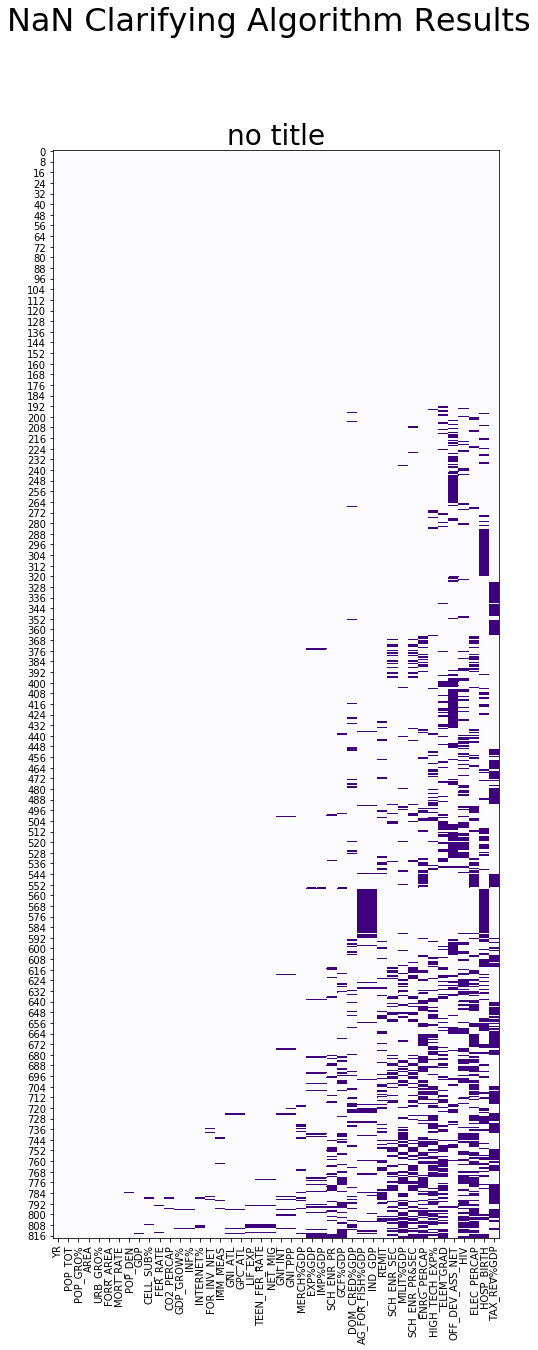

In [75]:
nan_heatmap(iter_4r)


In [83]:
def tips_index(df):
    """
    All NaN cell indices are identified. The (Rmin, C) are returned for each column. These tips are ideal sites to 
    check for the largest possible matrix with NaNs. 
    """
    r,c = np.where(df.isna())
    nan_tuples = list(zip(r.tolist(), c.tolist()))
    column_vals = set(map(lambda x : x[1], nan_tuples))
    col_bin_nan = [[t for t in nan_tuples if t[1] == c] for c in column_vals]
    #print(col_bin_nan)
    tips = [x[0] for x in col_bin_nan]
    return tips



tip_list = tips_index(iter_4r)

for t in tip_list:
    print(t)
    print(iter_4r.iloc[:t[0]+1, :t[1]+1].isnull().any().any() )

(784, 8)
True
(815, 9)
True
(788, 10)
True
(794, 11)
True
(788, 12)
True
(797, 13)
True
(797, 14)
True
(788, 15)
True
(736, 16)
True
(743, 17)
True
(725, 18)
True
(725, 19)
True
(794, 20)
True
(774, 21)
True
(774, 22)
True
(501, 23)
True
(501, 24)
True
(719, 25)
True
(375, 26)
True
(375, 27)
True
(500, 28)
True
(439, 29)
True
(197, 30)
True
(437, 31)
True
(437, 32)
True
(430, 33)
True
(368, 34)
True
(237, 35)
True
(208, 36)
True
(366, 37)
True
(195, 38)
True
(193, 39)
True
(203, 40)
True
(194, 41)
True
(201, 42)
True
(198, 43)
True
(325, 44)
True


In [108]:
def search_horizontally(r,c, df):
    if df.iloc[0:r+1, 0:c+1].isnull().any().any():
    #if area already has tuples inside, we can quit this point.
        return((0,0,0))
    while not df.iloc[0:r+1, 0:c+1].isnull().any().any():
        if c > len(df.columns):
            break
        c+=1
    c-=1
    return((r,c,r*c))

def search_vertically(r,c, df):
    if df.iloc[0:r+1, 0:c+1].isnull().any().any():
    #if area already has tuples inside, we can quit this point.
        return((0,0,0))
    while not df.iloc[0:r+1, 0:c+1].isnull().any().any():
        if r > len(df):
            break
        r+=1
    r-=1
    return((r,c,r*c))


def best_hv_nonan(tuple_ind, df):
    """
    searches horizontally and vertically from r-1, c-1 to identify the biggest window returns (r,c,r*c) for biggest.
    """
    #step back from NaN index and begin two searches.
    r,c = tuple_ind
    r_=r-1
    c_=c-1
    if df.iloc[0:r, 0:c].isnull().any().any():
        #if area already has tuples inside, we can quit this point.
        return(0,0,0)
    best_horz = search_horizontally(r_,c_, df)
    best_vert = search_vertically(r_,c_, df)
    #print(best_horz, best_vert)
    if best_horz[2] > best_vert[2] :
        return best_horz
    else :
        return best_vert
    
def best_nonan(df):
    collection = []
    tips = tips_index(df)
    for tip in tip_list :
        #print(f'at site {tip}')
        collection.append(best_hv_nonan(tip,iter_4r))
        sort_list = sorted(list(set(collection)), key=lambda x: x[2], reverse=True)                  
    return sort_list[0]
#nan_heatmap(iter_4r.iloc[:725,:23])
#iter_4r.iloc[:503, :23].isnull().any().any()  
best_nonan(iter_4r)

(724, 22, 15928)

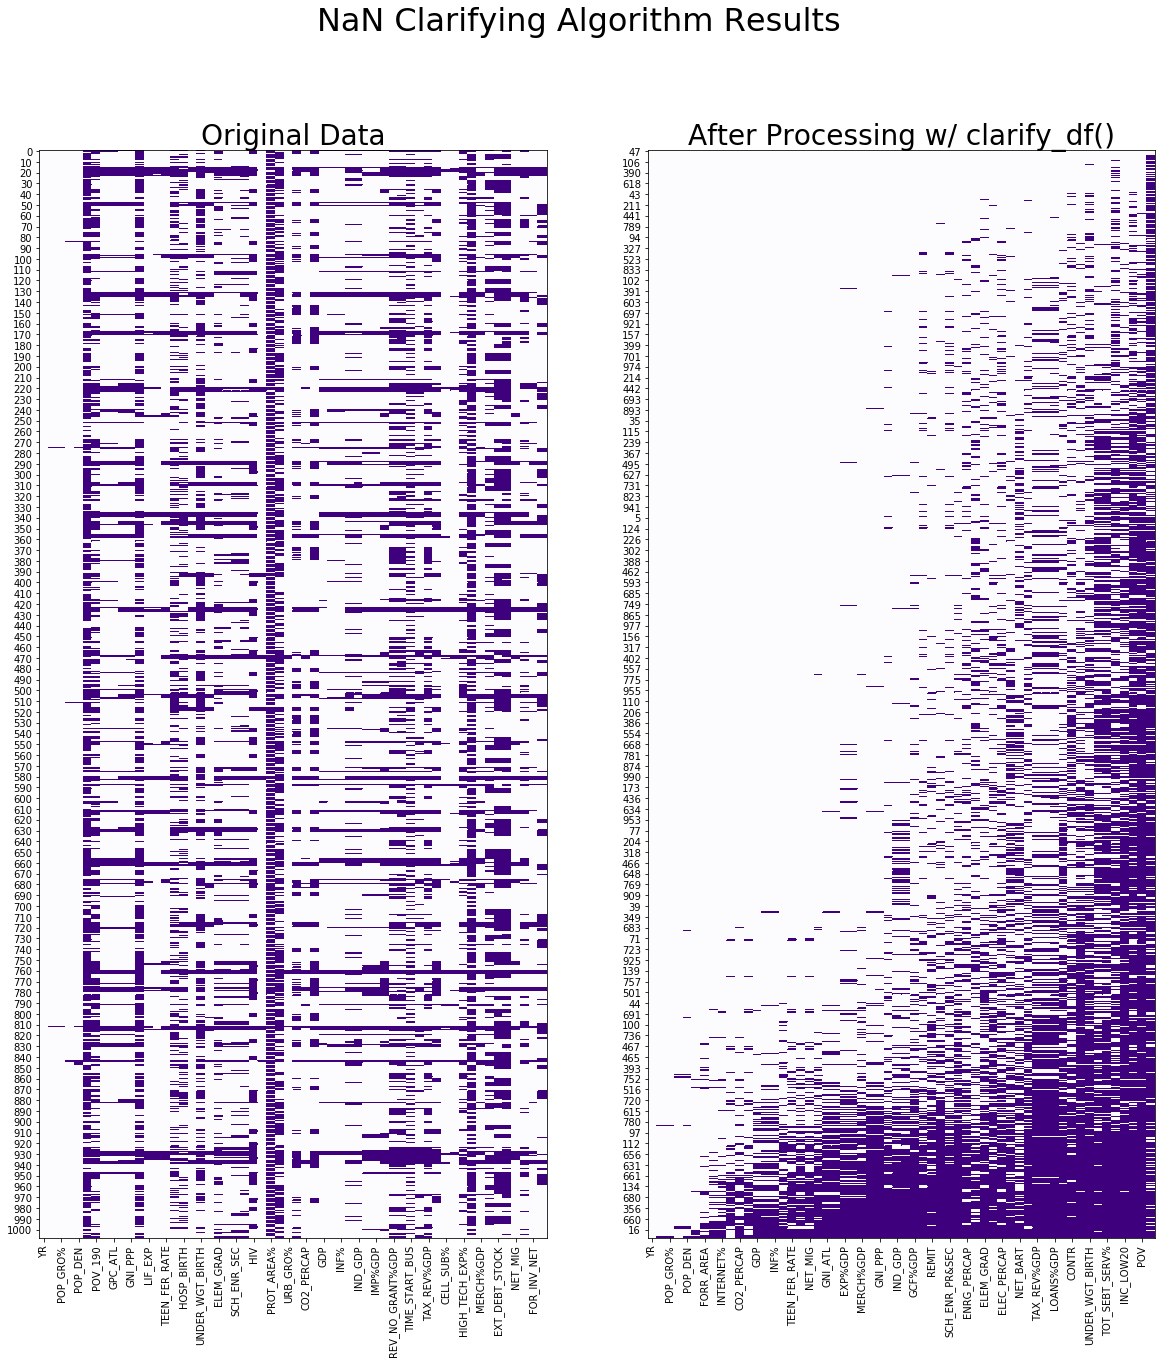

In [157]:
%matplotlib inline
import pandas as pd
import seaborn as sbn
from matplotlib import pyplot as plt
import numpy as np
import time

def clarify_df(df, heatmap=False):
    """
    clarify_df takes a dataframe and reogranizes the columns and rows so that the NaN values are most dense at the
    bottom and right sides of the dataframe. This allows easier selection of the area without NaN. 
    It returns the newly sorted df. 
    
    if keyword heatmap=True is passed, it will also print the original df (purple sites are NaN cells, and the 
    sorted cell df for comparison (it creates an output file called )
    """
    df2 = df.copy()
    df2 = df2.reset_index(drop=True)
    #print(df2)
    #print(df2.index, df2.shape)
    nan_col = [(c, df2[c].isna().sum()) for c in df2.columns]
    nan_col_sort = sorted(nan_col, key=lambda x : x[1], reverse=False)    
    col_order = [c[0] for c in nan_col_sort]
    #print(col_order)
    nan_row = [(int(r), df2.iloc[int(r)].isna().sum()) for r in df2.index]    
    nan_row_sort = sorted(nan_row, key=lambda x : x[1], reverse=False) 
    row_order = [r[0] for r in nan_row_sort]
    #print(row_order)
    extra_cols =[w for w in df2.columns if w not in col_order]    
    df3 = df2[extra_cols + col_order ]
    #print(df3)
    #print(row_order)
    extra_rows =[w for w in df3.index if int(w) not in row_order]
    df4 = df3.iloc[extra_rows + row_order ]
    #print(df4)
    if heatmap :
        mask1 = df2.isnull()
        f,(ax1,ax2) = plt.subplots(1,2, figsize=(20,20), sharey=False)
        f.suptitle("NaN Clarifying Algorithm Results", fontsize=32)
        ax1.set_title('Original Data', fontsize=28)
        sbn.heatmap(mask1.iloc[:,1:], vmin=0, vmax=10**-8, ax=ax1, cmap='Purples', cbar=False)
        mask2 = df4.isnull()
        sbn.heatmap(mask2.iloc[:,1:], vmin=0, vmax=10**-8, cmap='Purples', ax=ax2, cbar=False)
        ax2.set_title('After Processing w/ clarify_df()', fontsize=28)
        #ax2.title.set_text('First Iteration clarify_df()')  
        for _, spine in ax1.spines.items():
            spine.set_visible(True)
        for _, spine in ax2.spines.items():
            spine.set_visible(True)   
        #save plot
        import time
        timestr = time.strftime("%Y%m%d_%H%M%S")
        f.savefig( "./images/" + timestr + "_clarify.png")
        df4.to_pickle("./pickles/" + timestr + "_clarify.pkl")
        plt.show()
    return(df4)

#iter_1 = clarify_df(cdf, heatmap=True)
    

    

In [158]:
iter_1.shape

(1008, 59)

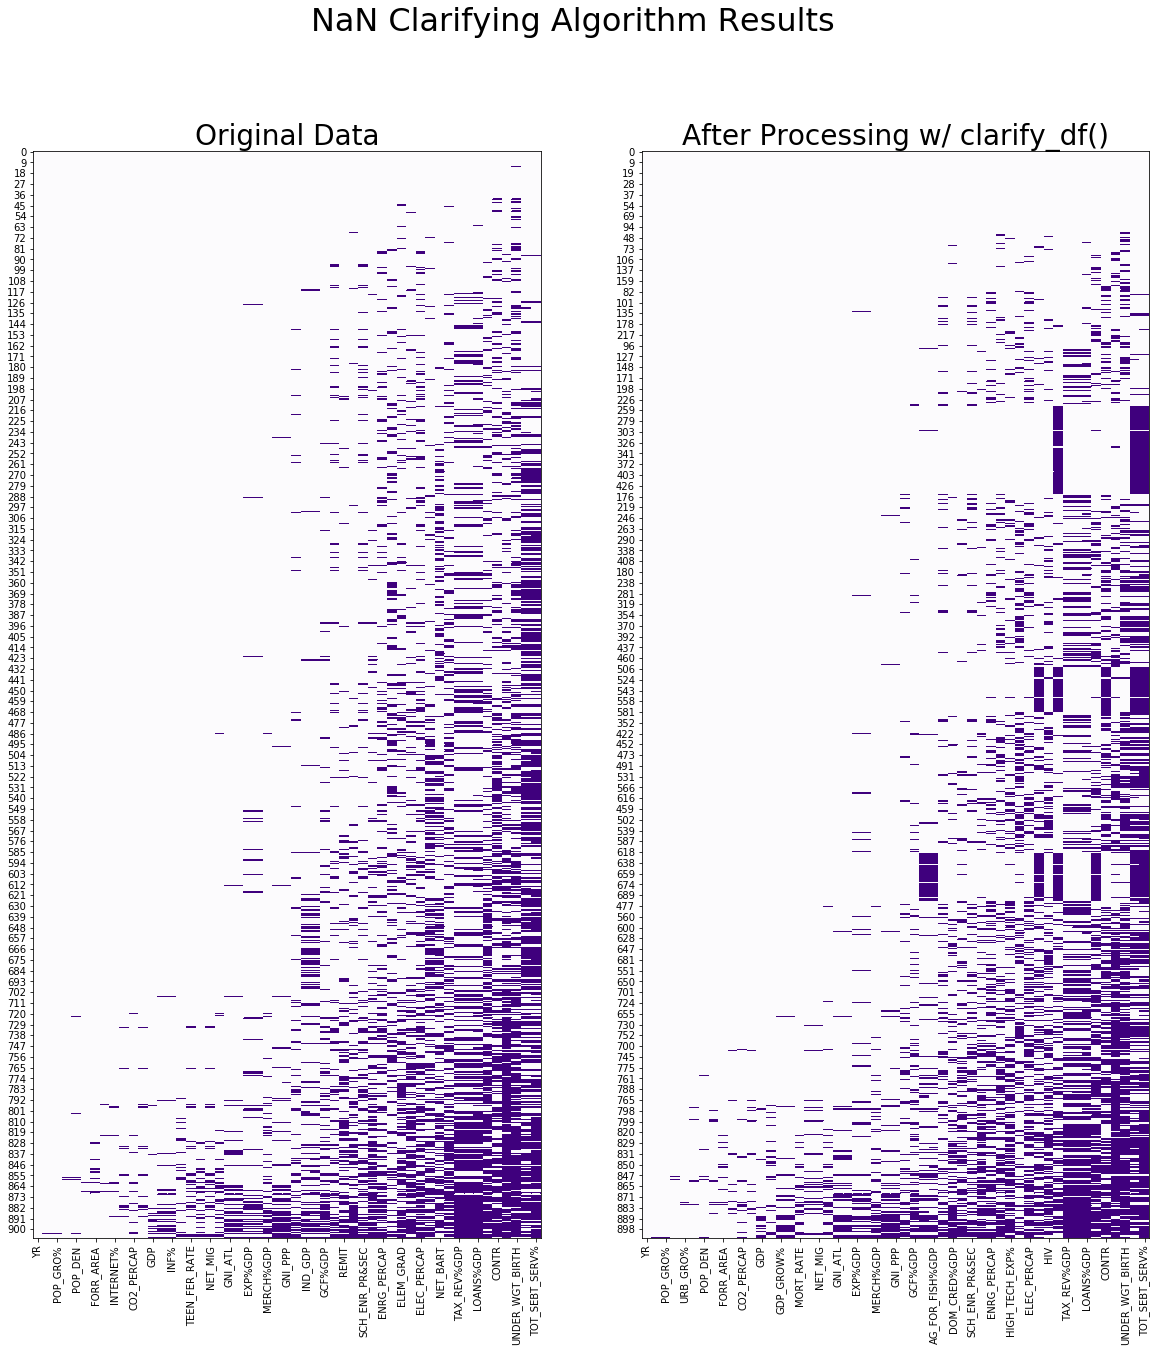

(908, 54)

In [159]:
def chop_by(df, chop_by=[0,0], heatmap=False):
    """
    chop_by takes a DataFrame and chop_by keyword argument. The argement can be integers, which are interpreted as 
    rows to chop and columns to chop. If the chop_by argument is provided as values less than 1, they are interpreted
    as fractions to be remove, i.e. [0.1, 0.05] removes 10% of rows from the bottom and 5% of columns from the 
    right-most side. Then clarify_df is called to reorder, generate heatmap and document. The heatmap argument is 
    forwarded to clarfy_df. True means the heatmap will be generated. 
    """
    import math
    ddf = df.copy()
    h,w = ddf.shape
    #if number is greater than one the intention must be to chop number of rows or columns
    if chop_by[0] >= 1 or chop_by[1] >= 1:
        chop_by[0] = math.floor(chop_by[0])
        chop_by[1] = math.floor(chop_by[1])
        chopped_df = ddf.iloc[0:len(ddf)-chop_by[0], 0:len(ddf.columns)-chop_by[1]]
        out_df = clarify_df(chopped_df, heatmap=heatmap)
    #if number is less than 1, then must mean a percentage of row or columns    
    else:
        row_height = math.ceil((1-chop_by[0])*h)
        col_width = math.ceil((1-chop_by[1])*w)
        chopped_df = ddf.iloc[0:row_height, 0:col_width]
        out_df = clarify_df(chopped_df, heatmap=heatmap)
    return out_df

#iter_2 = chop_by(iter_1, chop_by=[0.1,0.1], heatmap=True)
#iter_2.shape

In [149]:
iter_1.shape

(1008, 59)

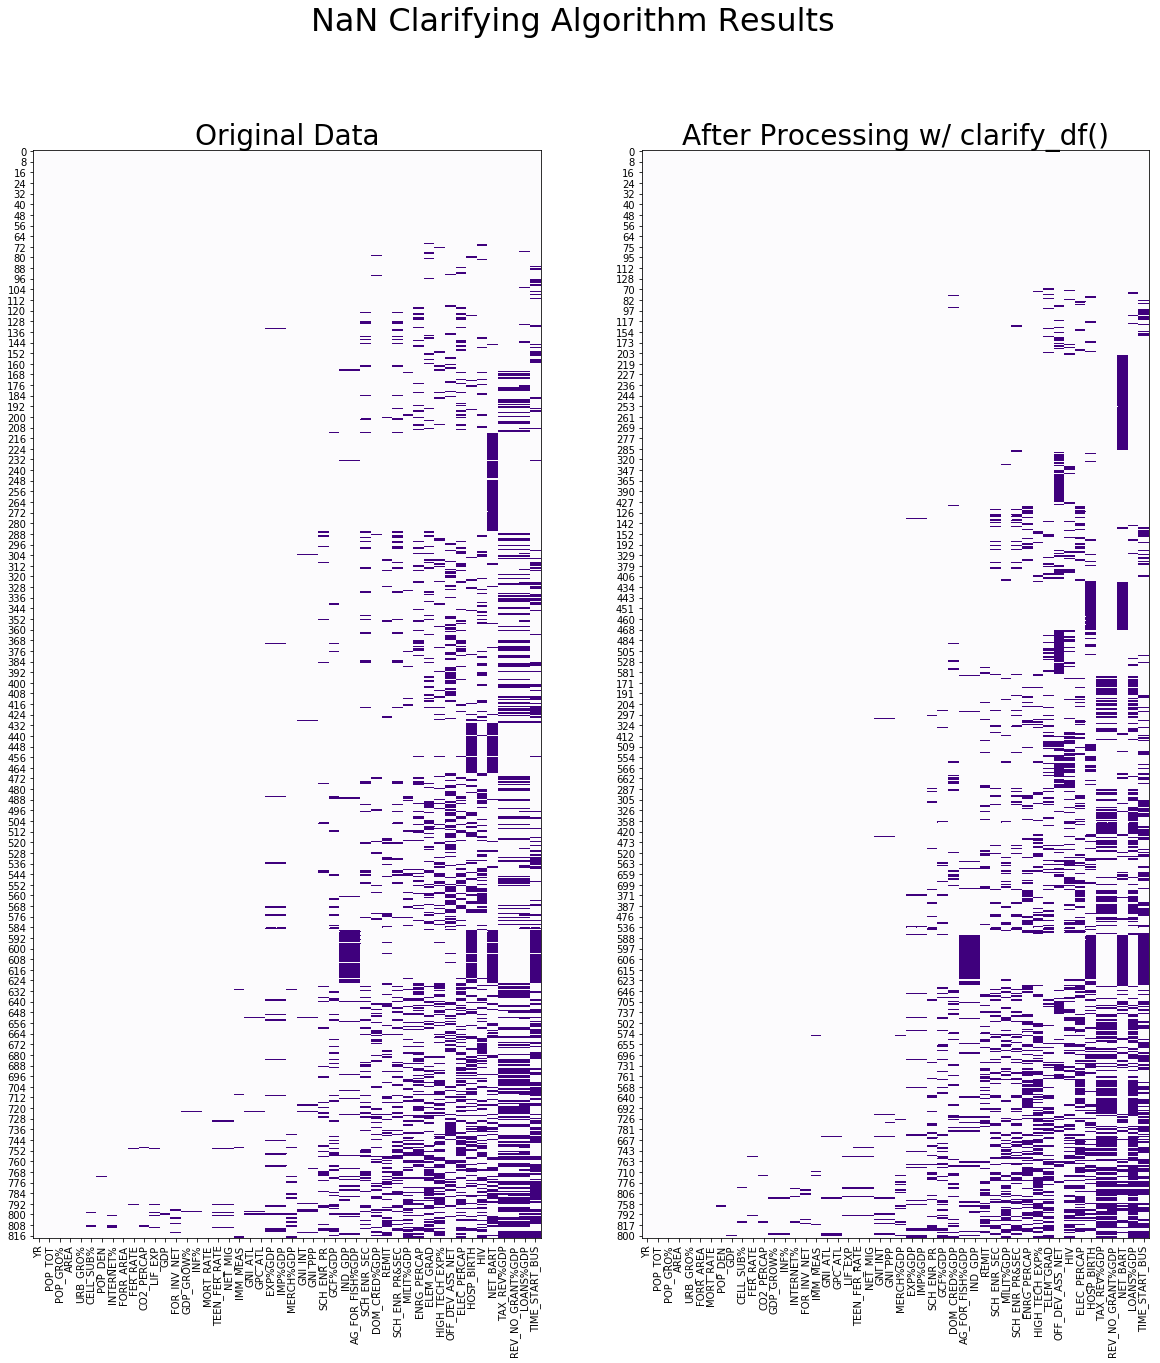

(818, 49)

In [160]:
iter_3 = chop_by(iter_2, chop_by=[0.1,0.1], heatmap=True)
iter_3.shape

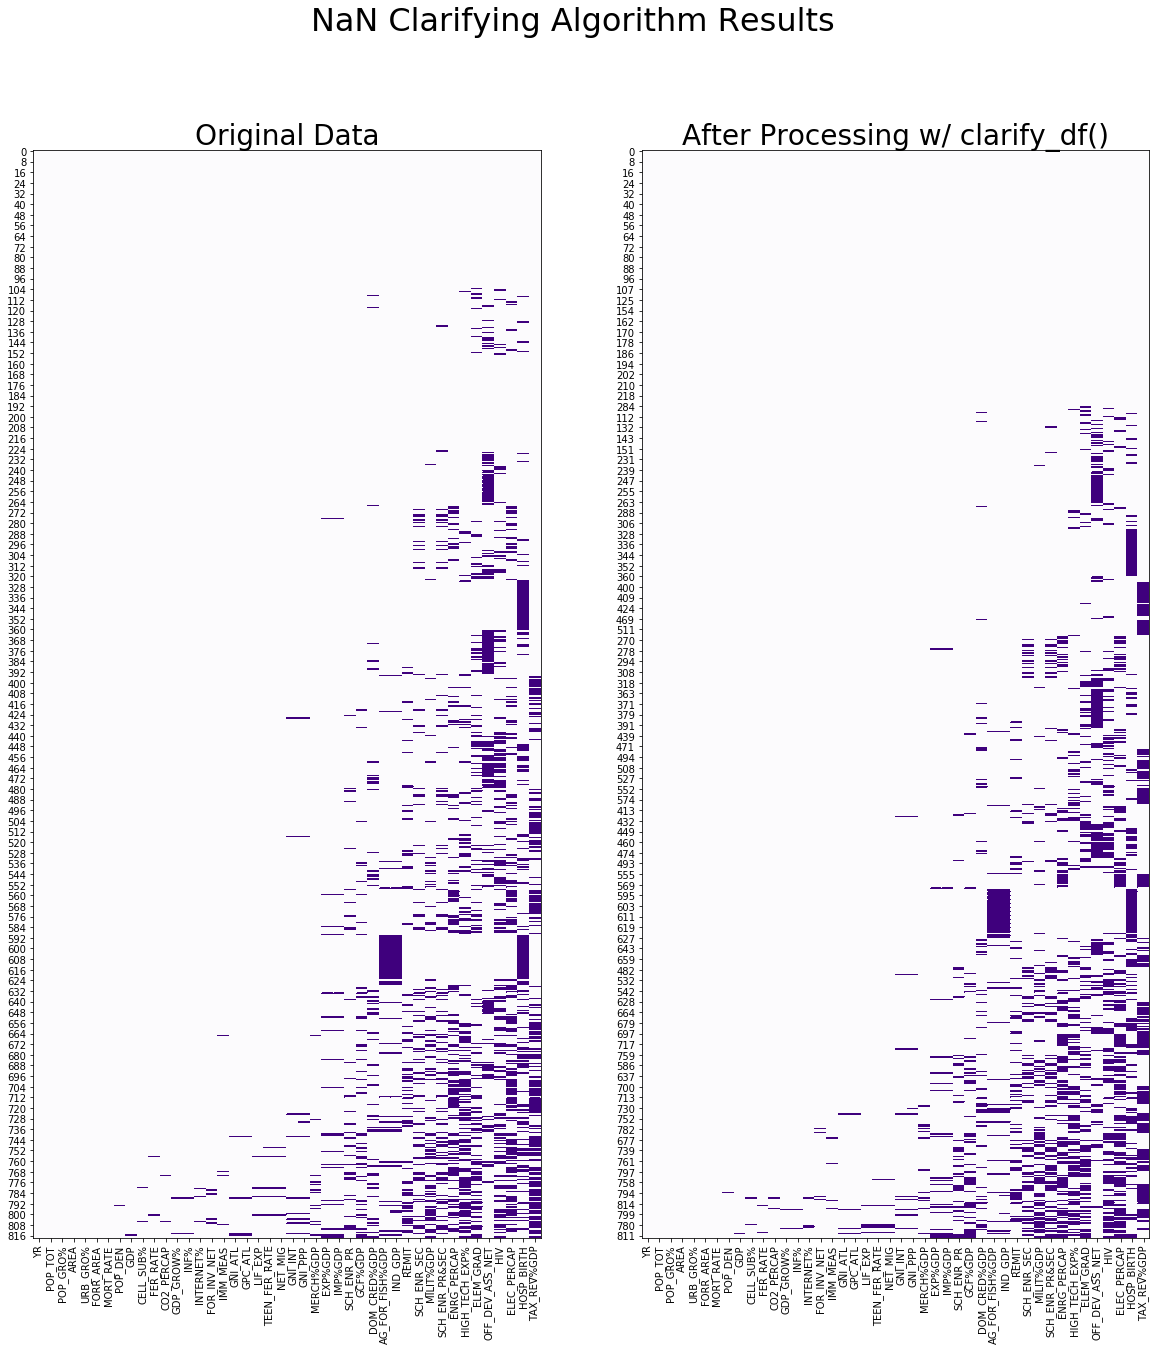

(818, 45)

In [150]:
iter_4 = chop_by(iter_3, chop_by=[0,0.1], heatmap=True)
iter_4.shape

In [161]:
iter_4.columns

Index(['CNT', 'YR', 'POP_TOT', 'POP_GRO%', 'AREA', 'URB_GRO%', 'FORR_AREA',
       'MORT_RATE', 'POP_DEN', 'GDP', 'CELL_SUB%', 'FER_RATE', 'CO2_PERCAP',
       'GDP_GROW%', 'INF%', 'INTERNET%', 'FOR_INV_NET', 'IMM_MEAS', 'GNI_ATL',
       'GPC_ATL', 'LIF_EXP', 'TEEN_FER_RATE', 'NET_MIG', 'GNI_INT', 'GNI_PPP',
       'MERCH%GDP', 'EXP%GDP', 'IMP%GDP', 'SCH_ENR_PR', 'GCF%GDP',
       'DOM_CRED%GDP', 'AG_FOR_FISH%GDP', 'IND_GDP', 'REMIT', 'SCH_ENR_SEC',
       'MILIT%GDP', 'SCH_ENR_PR&SEC', 'ENRG_PERCAP', 'HIGH_TECH_EXP%',
       'ELEM_GRAD', 'OFF_DEV_ASS_NET', 'HIV', 'ELEC_PERCAP', 'HOSP_BIRTH',
       'TAX_REV%GDP'],
      dtype='object')

In [163]:
#.value_counts()
iter_4

,CNT,YR,POP_TOT,POP_GRO%,AREA,URB_GRO%,FORR_AREA,MORT_RATE,POP_DEN,GDP,...,MILIT%GDP,SCH_ENR_PR&SEC,ENRG_PERCAP,HIGH_TECH_EXP%,ELEM_GRAD,OFF_DEV_ASS_NET,HIV,ELEC_PERCAP,HOSP_BIRTH,TAX_REV%GDP
0,ARM,2017.0,2.93,0.2,29.7,0.2,3.3,13.0,102.9,11.54,...,4.0,1.0,1018.0,6.0,90.0,326.8,0.2,1966.0,100.0,21.3
1,EGY,2017.0,97.55,1.9,1001.5,1.9,0.7,22.0,98.0,235.37,...,1.3,1.0,815.0,0.0,94.0,2130.3,0.1,1658.0,92.0,12.5
2,KAZ,2017.0,18.04,1.4,2724.9,1.5,33.1,10.0,6.7,159.41,...,0.8,1.0,4435.0,30.0,109.0,61.0,0.2,5600.0,99.0,9.9
3,MEX,2017.0,129.16,1.3,1964.4,1.6,660.4,13.0,66.4,1149.92,...,0.5,1.0,1488.0,15.0,101.0,809.3,0.3,2090.0,98.0,13.6
4,ZAF,2017.0,56.72,1.2,1219.1,2.0,92.4,37.0,46.8,349.42,...,1.0,1.0,2696.0,5.0,84.0,1181.4,18.8,4198.0,97.0,27.1
5,ALB,2010.0,2.91,-0.5,28.8,1.6,7.8,12.0,106.3,11.93,...,1.6,1.0,729.0,1.0,89.0,365.1,0.1,1943.0,99.0,18.0
6,DZA,2010.0,36.12,1.8,2381.7,2.9,19.2,27.0,15.2,161.21,...,3.5,1.0,1110.0,1.0,96.0,201.3,0.1,1013.0,97.0,34.4
7,ARM,2010.0,2.88,-0.4,29.7,-0.5,3.3,18.0,101.1,9.26,...,4.3,1.0,863.0,2.0,106.0,342.6,0.2,1726.0,100.0,17.1
8,BGD,2010.0,152.15,1.1,148.5,3.6,14.4,49.0,1168.8,115.28,...,1.3,1.0,201.0,0.0,66.0,1404.6,0.1,240.0,27.0,7.8
9,BGD,2017.0,164.67,1.0,147.6,3.2,14.3,32.0,1265.0,249.72,...,1.4,1.0,222.0,0.0,98.0,2503.6,0.1,310.0,50.0,8.8


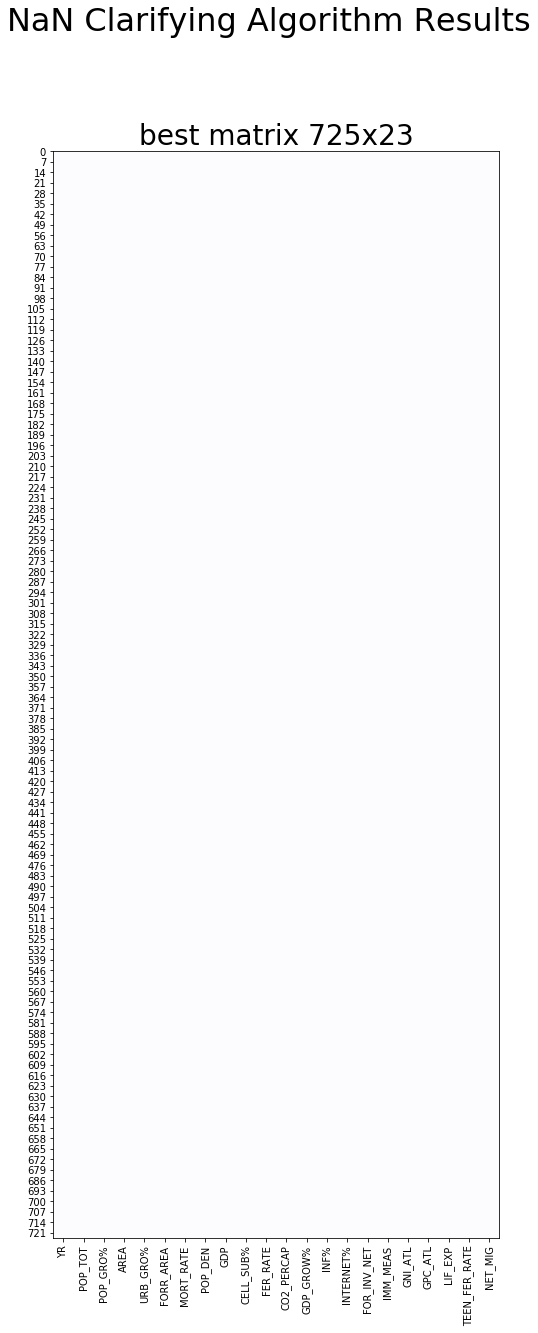

[(725, 23, 16675), (784, 16, 12544), (375, 30, 11250), (197, 38, 7486), (818, 8, 6544), (0, 0, 0)]


In [186]:
import math
def nanless_window(df, starting_ind=[10,10]):
    """
    begins searching from a seed location and returns the maximal no NaN matrix. In some cases, there are 
    more than one larget matrix that could be identified. Since this is for exploratory work, it is probably
    best to collect all. 
    """ 
    rows_max = len(df)
    cols_max = len(df.columns)
    r=starting_ind[0]
    c=starting_ind[1]
    rmove=1
    cmove=1
    #print(f'looking at {r},{c}')
    if df.iloc[0:r, 0:c].isnull().any().any() :
        #print("overshot")
        return(0,0,0) 
    while not df.iloc[0:r, 0:c].isnull().any().any() :
        if r <= rows_max:
            r+=rmove
        else:
            break
    r-=rmove
    while not df.iloc[0:r, 0:c].isnull().any().any() :
        if c <= cols_max:
            c+=cmove
        else:
            break
    c-=cmove
    return((r,c,r*c))
    


iter_4r = iter_4.reset_index(drop=True)    

collection=[]
#generate 5 internal starting points for rows and columns
row_points = np.linspace(0,len(iter_4r),7)[1:-1]
col_points = np.linspace(0,len(iter_4r.columns),7)[1:-1]
for r in row_points :
    r = math.floor(r)
    for c in col_points:
        c = math.floor(c)
        out = nanless_window(iter_4r, starting_ind=[r,c])
        collection.append(out)

collection = sorted(list(set(collection)), key=lambda x : x[2], reverse=True)
r_, c_, _ = collection[0] 

nan_heatmap(iter_4r.iloc[:r_,:c_], title=f'best matrix {r_}x{c_}')
any_nans = iter_4.iloc[:r_, :c_].isnull().any().any()


#out = nanless_window(iter_4, starting_ind=[10,30])
print(collection)
#nan_heatmap(out) 
#nan_heatmap(iter_4.) 
    

In [12]:

def nan_heatmap(df, title='no title'):
    import time
    """
    nan_heatmap shows where the NaN cells are in a dataframe (purple is NaN). The heatmap is saved with a timestamp
    the data frame is pickled with the same timestamp. 
    """
    mask1 = df.isnull()
    f, ax1 = plt.subplots(1,1, figsize=(8,20), sharey=False)
    f.suptitle("NaN Clarifying Algorithm Results", fontsize=32)
    ax1.set_title(title, fontsize=28)
    sbn.heatmap(mask1.iloc[:,1:], vmin=0, vmax=10**-8, ax=ax1, cmap='Purples', cbar=False)
    #mask2 = df4.isnull()
    #sbn.heatmap(mask2.iloc[:,1:], vmin=0, vmax=10**-8, cmap='Purples', ax=ax2, cbar=False)
    #ax2.set_title('First Iteration clarify_df()', fontsize=28)
    #ax2.title.set_text('First Iteration clarify_df()')  
    for _, spine in ax1.spines.items():
        spine.set_visible(True)
    #for _, spine in ax2.spines.items():
    #    spine.set_visible(True)   
    #save plot
    timestr = time.strftime("%Y%m%d_%H%M%S")
    #f.savefig( "./images/" + timestr + "_clarify.png")
    #df.to_pickle( "./pickles/" + timestr + "_clarify.pkl")
    plt.show()

#iter_4r = iter_4.reset_index(drop=True)    
#nan_heatmap(iter_4r)    

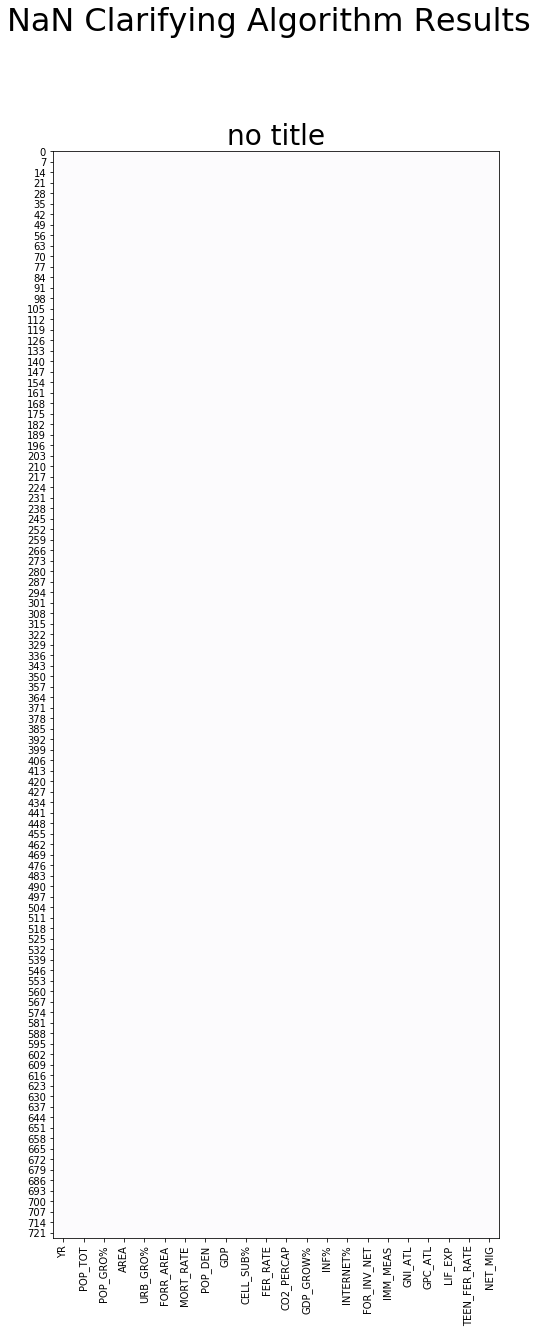

False

In [62]:
nan_heatmap(iter_4r.iloc[:725,:23])
iter_4r.iloc[:725, :23].isnull().any().any()

     CNT      YR  POP_TOT  POP_GRO%    AREA  URB_GRO%  FORR_AREA  MORT_RATE  \
0    ARM  2017.0     2.93       0.2    29.7       0.2        3.3       13.0   
1    EGY  2017.0    97.55       1.9  1001.5       1.9        0.7       22.0   
2    KAZ  2017.0    18.04       1.4  2724.9       1.5       33.1       10.0   
3    MEX  2017.0   129.16       1.3  1964.4       1.6      660.4       13.0   
4    ZAF  2017.0    56.72       1.2  1219.1       2.0       92.4       37.0   
5    ALB  2010.0     2.91      -0.5    28.8       1.6        7.8       12.0   
6    DZA  2010.0    36.12       1.8  2381.7       2.9       19.2       27.0   
7    ARM  2010.0     2.88      -0.4    29.7      -0.5        3.3       18.0   
8    BGD  2010.0   152.15       1.1   148.5       3.6       14.4       49.0   
9    BGD  2017.0   164.67       1.0   147.6       3.2       14.3       32.0   
10   BOL  2010.0     9.92       1.6  1098.6       2.3      562.1       46.0   
11   COL  2010.0    45.92       1.1  1141.8       1.

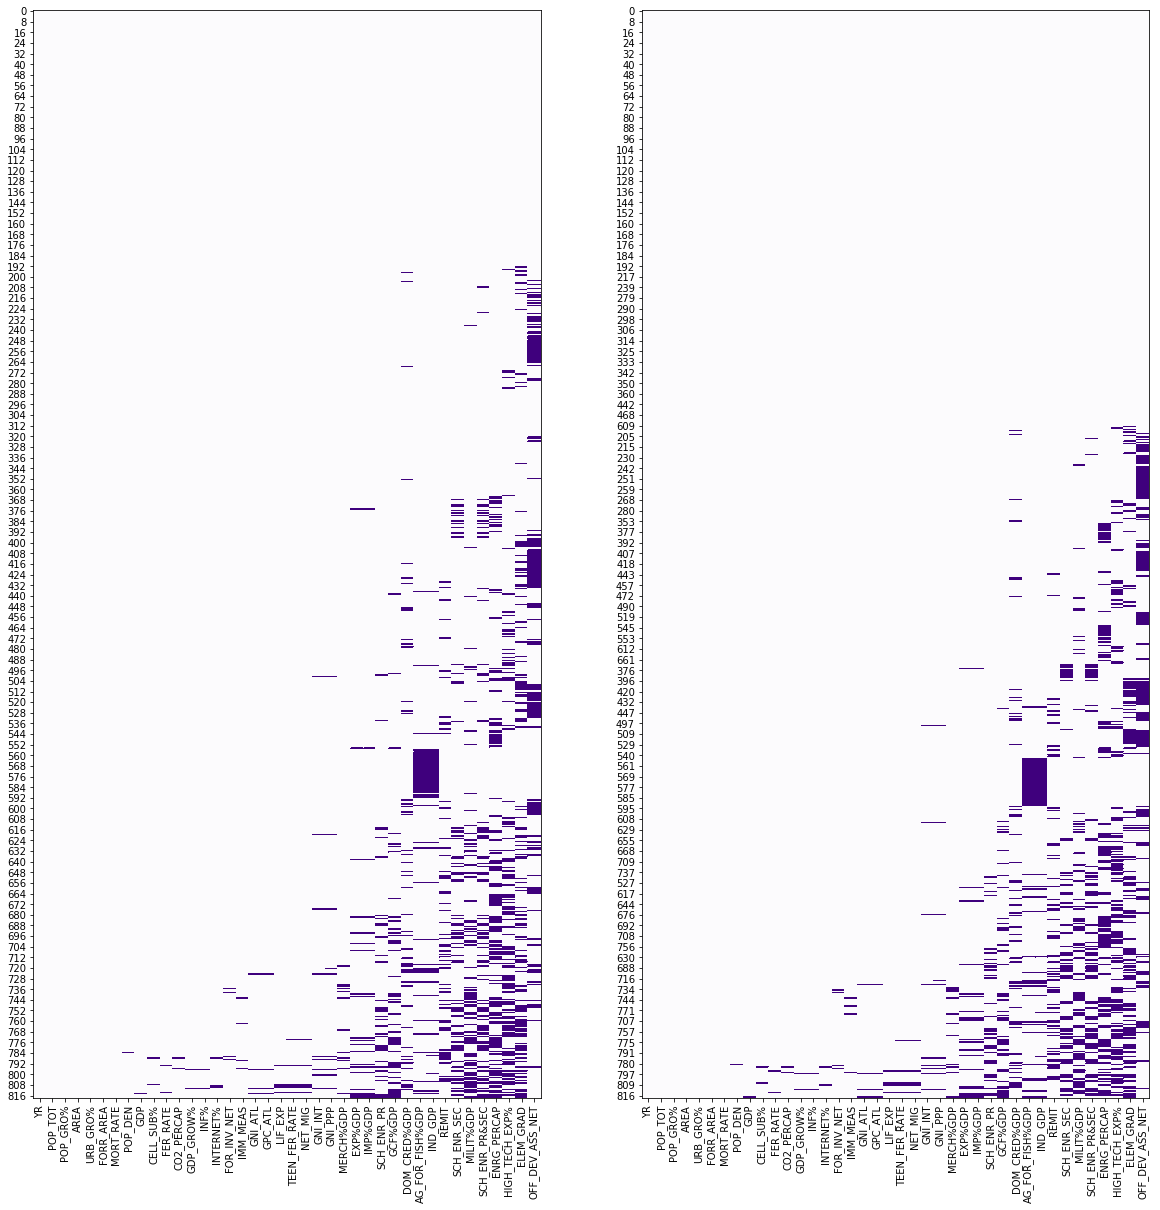

(818, 41)

     CNT      YR  POP_TOT  POP_GRO%    AREA  URB_GRO%  FORR_AREA  MORT_RATE  \
0    ARM  2017.0     2.93       0.2    29.7       0.2        3.3       13.0   
1    EGY  2017.0    97.55       1.9  1001.5       1.9        0.7       22.0   
2    KAZ  2017.0    18.04       1.4  2724.9       1.5       33.1       10.0   
3    MEX  2017.0   129.16       1.3  1964.4       1.6      660.4       13.0   
4    ZAF  2017.0    56.72       1.2  1219.1       2.0       92.4       37.0   
5    ALB  2010.0     2.91      -0.5    28.8       1.6        7.8       12.0   
6    DZA  2010.0    36.12       1.8  2381.7       2.9       19.2       27.0   
7    ARM  2010.0     2.88      -0.4    29.7      -0.5        3.3       18.0   
8    BGD  2010.0   152.15       1.1   148.5       3.6       14.4       49.0   
9    BGD  2017.0   164.67       1.0   147.6       3.2       14.3       32.0   
10   BOL  2010.0     9.92       1.6  1098.6       2.3      562.1       46.0   
11   COL  2010.0    45.92       1.1  1141.8       1.

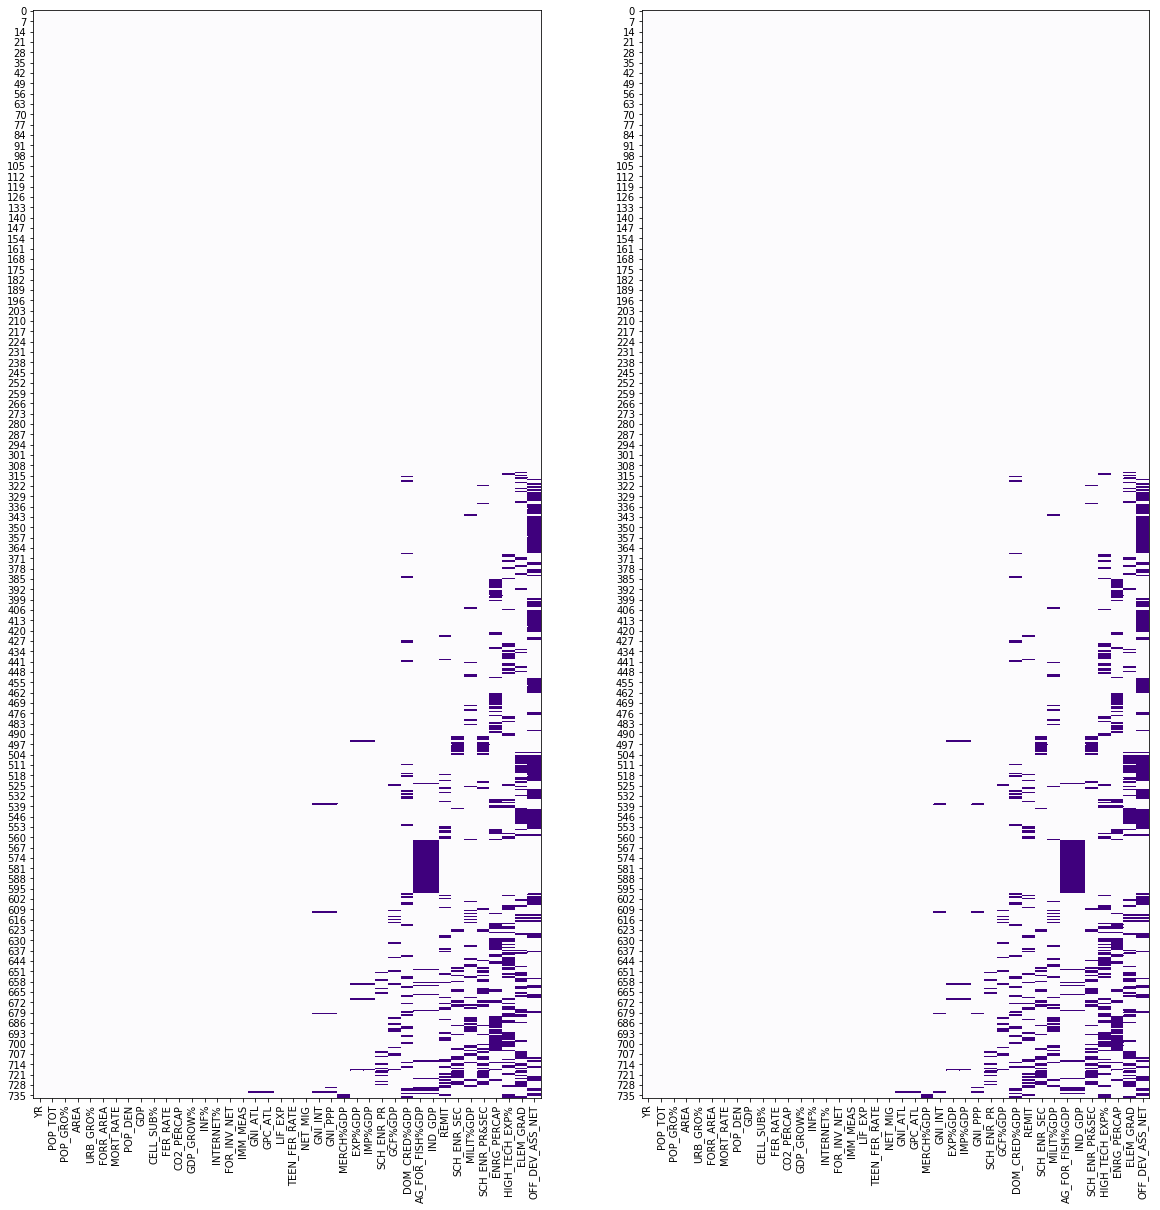

(737, 41)

In [208]:
iter_6 = chop_ten(iter_5, chop_by=[0.1,0], heatmap=True)
iter_6.shape

In [17]:
nan_row = [(int(r), cdf.iloc[int(r)].isna().sum()) for r in cdf.index]

In [18]:
nan_row

[(0, 34),
 (1, 20),
 (2, 9),
 (3, 10),
 (4, 12),
 (5, 8),
 (6, 10),
 (7, 7),
 (8, 15),
 (9, 2),
 (10, 1),
 (11, 7),
 (12, 7),
 (13, 6),
 (14, 1),
 (15, 11),
 (16, 49),
 (17, 42),
 (18, 44),
 (19, 43),
 (20, 44),
 (21, 39),
 (22, 38),
 (23, 38),
 (24, 16),
 (25, 7),
 (26, 4),
 (27, 11),
 (28, 12),
 (29, 8),
 (30, 10),
 (31, 7),
 (32, 12),
 (33, 8),
 (34, 10),
 (35, 7),
 (36, 19),
 (37, 17),
 (38, 12),
 (39, 13),
 (40, 8),
 (41, 4),
 (42, 4),
 (43, 2),
 (44, 17),
 (45, 6),
 (46, 1),
 (47, 0),
 (48, 41),
 (49, 25),
 (50, 26),
 (51, 37),
 (52, 12),
 (53, 8),
 (54, 9),
 (55, 9),
 (56, 14),
 (57, 8),
 (58, 7),
 (59, 7),
 (60, 18),
 (61, 2),
 (62, 5),
 (63, 7),
 (64, 16),
 (65, 15),
 (66, 14),
 (67, 15),
 (68, 12),
 (69, 14),
 (70, 11),
 (71, 14),
 (72, 9),
 (73, 7),
 (74, 1),
 (75, 1),
 (76, 18),
 (77, 12),
 (78, 9),
 (79, 15),
 (80, 15),
 (81, 5),
 (82, 2),
 (83, 2),
 (84, 23),
 (85, 9),
 (86, 10),
 (87, 11),
 (88, 7),
 (89, 7),
 (90, 6),
 (91, 7),
 (92, 13),
 (93, 3),
 (94, 3),
 (95, 4),
 

In [ ]:
def order(frame,var):
    if type(var) is str:
        var = [var] #let the command take a string or list
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

#single pass to associate column names with NaN count, 

df.isna().sum()
#df.sort_index(ascending=False)
#df.reindex(["Z", "C", "A"])